In [5]:
import tweepy
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer #Valence Aware Dictionary and sEntiment Reasoner lexicon
import numpy as np
sentiment = SentimentIntensityAnalyzer()
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import config as config

In [2]:
#https://medium.com/black-tech-diva/hide-your-api-keys-7635e181a06c

In [6]:
consumer_key = config.consumer_key
consumer_secret = config.consumer_secret
access_key = config.access_key
access_secret = config.access_secret

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_key, access_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)

In [7]:
swords = set(stopwords.words('english')) #set nltk stopword list equal to a variable
swords.update(['http', 'co', 'http co', 'ha', 'wa','amp']) #place to add custom stop words
 #add words to stopwords list
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'\w+') #create tokenizer to remove punctuation
cvec = CountVectorizer(stop_words=swords, #remove stop words
                       ngram_range=(1,3),#single, paired, and triplet word patterns
                       max_df=.3, #ngram has to appear in given percentage or less of posts
                       min_df=1, #ngram has to appear at least this many times
                       max_features=1_000) #maximum 1k features

def tokemmetizer(dataframe): #create function to tokenize and lemmatize
    X = dataframe['text'] #analyze text
    X_tokens = [tokenizer.tokenize(word) for word in X] #tokenize all words
    X_lem = []
    for item in X_tokens:
        X_post = []
        for word in item:
            X_post.append(lemmatizer.lemmatize(word)) #remove stop words
        X_lem.append(' '.join(X_post)) #rejoin lemmatized word list into strings
    #print(type(X_lem))
    X_c = cvec.fit_transform(X_lem) #pass posts through count vectorizer
    X_c_df = pd.DataFrame(X_c.todense(), columns=cvec.get_feature_names()) #make df showing word frequency
    return X_c_df #return dataframe of values 

In [8]:
def osent(score):
    if score > 0:
        return 'positive'
    elif score < 0:
        return 'negative'
    elif score == 0:
        return 'neutral'
    else:
        return 'ERROR'

In [9]:
def desent(keyword, quantity=1000):
    search_word = keyword
    all_tweets = []
    new_search = search_word + '-filter:retweets'
    for tweet in tweepy.Cursor(api.search, q=new_search, count=100,
                              lang='en', since_id=0).items():
        new = [tweet.created_at, tweet.id, tweet.text,
           tweet.user.screen_name, tweet.user.name, tweet.user.location]
        all_tweets.append(new)
        if len(all_tweets) == quantity: #stop at limit, default 1000
            break
    #create dataframe from list
    df = pd.DataFrame(all_tweets, columns=['created_at', 'id', 'text', 'screen_name', 'name', 'location'])
    
    #create new columns of sentiment
    df['neg_sent'] = [list(sentiment.polarity_scores(text).values())[0] for text in df['text']] 
    df['neu_sent'] = [list(sentiment.polarity_scores(text).values())[1] for text in df['text']] 
    df['pos_sent'] = [list(sentiment.polarity_scores(text).values())[2] for text in df['text']] 
    df['comp_sent'] = [list(sentiment.polarity_scores(text).values())[3] for text in df['text']]
    df['overall_sent'] = [osent(score) for score in df['comp_sent']] #rate rows as positive, negative, or neutral
    #print(df['overall_sent'].value_counts(normalize=True)) #print breakdown of sentiment
    plt.pie(df['overall_sent'].value_counts(normalize=True), 
            labels=list(dict(df['overall_sent'].value_counts()).keys()))
    plt.legend()
    plt.show()
    
    #sort tweets by composite score into postitive (greater than 0), negative (less than 0), or neutral (exactly 0)
    neutral = df[df['comp_sent']==0].copy() #neutral
    positive = df[df['comp_sent']>0].copy() #positive
    negative = df[df['comp_sent']<0].copy() #negative
    dflist = [neutral, positive, negative] #list of dataframes
    titles = ['neutral', 'positive', 'negative'] #list of df names (for plots)
    
    for n in range(len(dflist)): #iterate through list of dfs, find most common words in each
        new_df = tokemmetizer(dflist[n]) #run function on given dataframe
        new_df.sum().sort_values(ascending=False).head(10).plot.barh(
            fontsize = '20',
            color='chartreuse'); #make bar chart of most frequent 10 words  
        plt.title(f'Most frequent words associated with {titles[n]} sentiment', size=25)
        plt.show(); #display each plot
    return 'Success!'

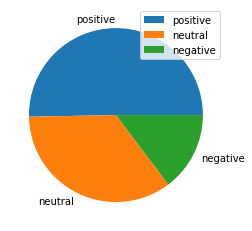

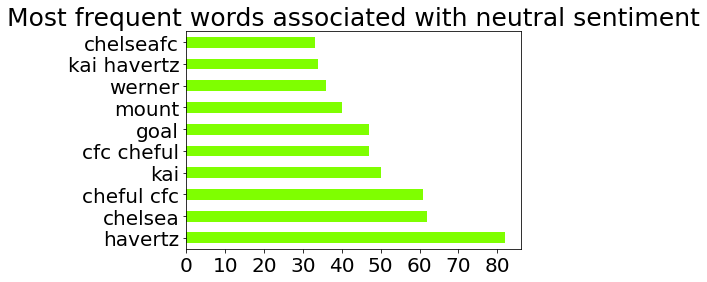

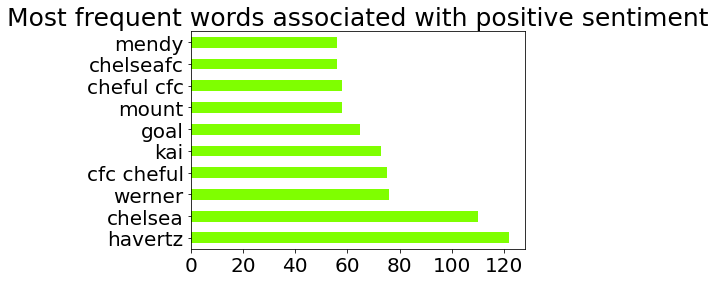

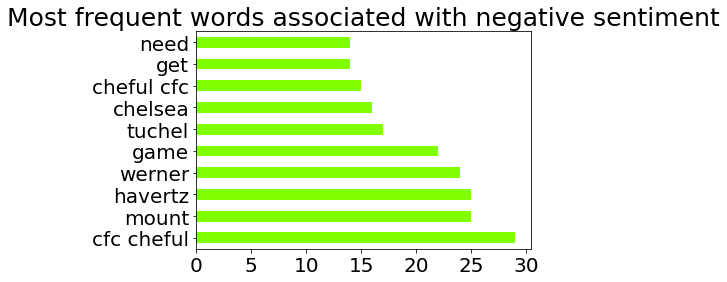

'Success!'

In [10]:
desent('#cfc')